In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [ ]:
def U_LJ(dist_table, epsilon, sigma):
  d = dist_table
  d = np.where(d == 0, np.inf, d)
  U = 4*epsilon*((sigma/d)**12 - (sigma/d)**6)
  return U

def F_LJ(distances, epsilon, sigma): #dist_table needed
  d = np.linalg.norm(distances, axis = 2)
  d = np.where(d == 0, 1, d)
  F = 24*epsilon/(d**2)*(2*(sigma/d)**12 - (sigma/d)**6)
  F = np.transpose(np.array([F]*np.size(distances, axis = 2)), axes = (1, 2, 0))
  F = np.multiply(F, -distances)
  return F

d = np.linspace(0.95, 2, 1000)
sigma = 1
epsilon = 1
#plt.plot(d, 4*epsilon*((sigma/d)**12 - (sigma/d)**6))


In [ ]:
class particle():
    def __init__(self, pos, v):
        self.pos = pos
        self.x = pos[0]
        self.y = pos[1]
        self.z = pos[2]

        self.v = v
        self.vx = v[0]
        self.vy = v[1]
        self.vz = v[2]

class system():
    def __init__(self, N, positions = None, velocities = None, box_size = np.array([1, 1, 1]), eps = 0.05, sigma = 0.1, r_c = 0.04):

        self.particles = np.empty(N, dtype=particle)

        self.N = N
        self.size = box_size
        self.eps = eps
        self.sigma = sigma
        self.r_c = r_c
        self.time = 0

        self.positions = (positions if positions is not None else np.random.rand(N, 3))
        self.positions = self.positions*self.size
        self.velocities = (velocities if velocities is not None else np.random.rand(N, 3))
        self.particles = [particle(self.positions[i], self.velocities[i]) for i in range(N)]

        self.trajectories = self.positions.reshape(1, N, 3)
        self.v_table = self.velocities.reshape(1, N, 3)
        self.timeline = np.array([0])
        self.KE = np.sum([np.linalg.norm(self.velocities[i])**2 for i in range(N)])/2
        self.PE = np.sum(U_LJ(self.positions, eps, sigma))
        self.rms_v = np.sqrt(2*self.KE/N)


    def get_positions(self):
        return np.array([self.particles[i].pos for i in range(self.N)])

    def get_velocities(self):
        return np.array([self.particles[i].v for i in range(self.N)])

    def distances(self):
        L = self.size
        r = np.array([self.positions]*np.size(self.positions, axis = 0))
        r = r - np.transpose(r, axes = (1, 0, 2))
        r = np.multiply(np.sign(r), (self.size/2) - np.abs(np.abs(r) - self.size/2))
        return r

    def dist_table(self):
        return np.linalg.norm(self.distances(), axis = 2)

    def forces(self, eps = None, sigma = None):
        eps = self.eps if eps is None else eps
        sigma = self.sigma if sigma is None else sigma

        forces = F_LJ(self.distances(), eps, sigma)
        forces = np.sum(forces, axis = 1)
        return forces

    def min_dist(self):
        return np.min(self.dist_table() + np.linalg.norm(self.size)*np.eye(self.N))

    def update(self, dt):
        #used for the first update only
        self.positions = self.positions + self.velocities*dt
        self.positions = self.positions % self.size #PBC
        self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
        self.timeline = np.append(self.timeline, self.time + dt)
        self.time += dt

    def verlet_update(self, dt, adaptive_timestep):
        #used for all other updates
        forces = self.forces()
        if adaptive_timestep:
            dt1 = self.timeline[-1] - self.timeline[-2]
            self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
            self.positions = (1 + dt/dt1)*self.positions + 0.5*forces*dt*(dt + dt1) - (dt/dt1)*self.trajectories[-2]
            #self.v_table = np.append(self.v_table, ((self.positions - self.trajectories[-2])/(dt + dt1)).reshape(1, self.N, 3), axis = 0)
            self.v_table = np.append(self.v_table, ((self.positions - self.trajectories[-1])/dt).reshape(1, self.N, 3), axis = 0)

            self.positions = self.positions % self.size #PBC
            self.time += dt
            self.timeline = np.append(self.timeline, self.time)

        else:
            self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
            self.positions = 2*self.positions - self.trajectories[-2] + forces*(dt**2)
            self.v_table = np.append(self.v_table, ((self.positions - self.trajectories[-1])/(2*dt)).reshape(1, self.N, 3), axis = 0)
            self.positions = self.positions % self.size #PBC
            self.time += dt
            self.timeline = np.append(self.timeline, self.time)
        self.time += dt

    def vel_verlet_update(self, dt):
        forces = self.forces()
        new_positions = self.positions + self.velocities*dt + 0.5*forces*(dt**2)

        L = self.size
        new_distances = np.array([new_positions]*np.size(new_positions, axis = 0))
        new_distances = new_distances - np.transpose(new_distances, axes = (1, 0, 2))
        new_distances = np.multiply(np.sign(new_distances), (self.size/2) - np.abs(np.abs(new_distances) - self.size/2))

        new_forces = np.sum(F_LJ(new_distances, self.eps, self.sigma), axis = 1)

        v = self.velocities + (forces + new_forces)*dt/2

        self.positions = new_positions
        self.velocities = v

        self.v_table = np.append(self.v_table, v.reshape(1, self.N, 3), axis = 0)
        self.trajectories = np.append(self.trajectories, new_positions.reshape(1, self.N, 3), axis = 0)
        self.time += dt

    def run(self, num_steps, adaptive_timestep = True):
        run_time = self.time
        dt = sigma/100
        self.update(dt)
        self.trajectories = np.delete(self.trajectories, -1, axis = 0)
        for i in range(num_steps-1):
            if adaptive_timestep:
                dt = self.min_dist()/np.max(np.linalg.norm(self.v_table[-1], axis = 1))
            self.verlet_update(dt=dt, adaptive_timestep=adaptive_timestep)
            run_time += dt
        print("run complete, run time:", run_time)
        self.time = run_time
        return self.trajectories


### Running a system

In [ ]:
positions = np.array([[i, j, k] for i in range(6) for j in range(6) for k in range(6)])*0.15 + 0.1
positions.shape[0]

216

In [ ]:
s = system(positions.shape[0], positions)
s.min_dist(), s.rms_v, s.time, s.v_table.shape

(0.1499999999999999, 0.9873784637328492, 0, (1, 216, 3))

(array([212.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.06979131e+00, 1.00039169e+09, 2.00078338e+09, 3.00117507e+09,
        4.00156676e+09, 5.00195845e+09, 6.00235014e+09, 7.00274183e+09,
        8.00313352e+09, 9.00352521e+09, 1.00039169e+10, 1.10043086e+10,
        1.20047003e+10, 1.30050920e+10, 1.40054837e+10, 1.50058753e+10,
        1.60062670e+10, 1.70066587e+10, 1.80070504e+10, 1.90074421e+10,
        2.00078338e+10, 2.10082255e+10, 2.20086172e+10, 2.30090089e+10,
        2.40094006e+10, 2.50097922e+10, 2.60101839e+10, 2.70105756e+10,
        2.80109673e+10, 2.90113590e+10, 3.00117507e+10]),
 <BarContainer object of 30 artists>)

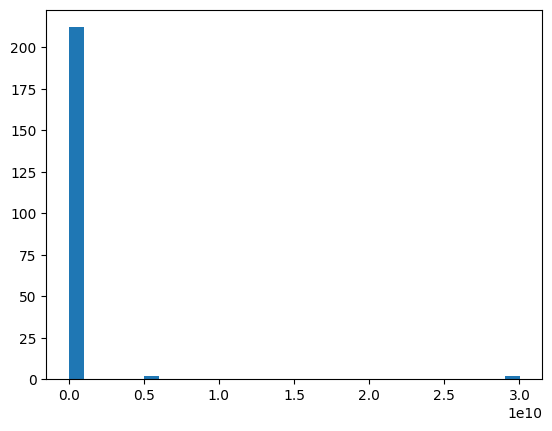

In [ ]:
a = np.array([])
for i in range(1000):
    s.vel_verlet_update(s.sigma/100)
    a = np.append(a, np.max(np.abs(s.forces())))
plt.hist(np.linalg.norm(s.v_table[-1], axis = 1).flatten(), bins = 30)


In [ ]:
s.time

1.0000000000000007

In [ ]:
a

array([8.96428572e-01, 9.15475785e-01, 9.35113947e-01, 9.55336459e-01,
       9.76133061e-01, 9.97489257e-01, 1.01938567e+00, 1.04179729e+00,
       1.06469267e+00, 1.08803296e+00, 1.11177083e+00, 1.13584930e+00,
       1.16020031e+00, 1.18474321e+00, 1.20938303e+00, 1.23400842e+00,
       1.25848948e+00, 1.28267522e+00, 1.30639065e+00, 1.32943361e+00,
       1.35157107e+00, 1.37253506e+00, 1.39201804e+00, 1.40966763e+00,
       1.42508080e+00, 1.43779726e+00, 1.44729206e+00, 1.45296733e+00,
       1.45414303e+00, 1.46869163e+00, 1.48999002e+00, 1.51109654e+00,
       1.53195822e+00, 1.55251728e+00, 1.57271068e+00, 1.59246981e+00,
       1.61172001e+00, 1.63038013e+00, 1.64836206e+00, 1.66557021e+00,
       1.68190094e+00, 1.69724203e+00, 1.71147203e+00, 1.80622986e+00,
       2.33861015e+00, 2.95974770e+00, 3.68125262e+00, 4.51557087e+00,
       5.47577624e+00, 6.57523219e+00, 7.82708530e+00, 9.24354870e+00,
       1.08349352e+01, 1.26084083e+01, 1.45664390e+01, 1.67049924e+01,
      

(-50.0, 1050.0)

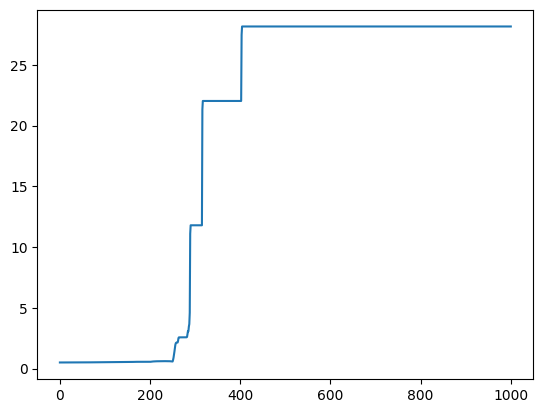

In [ ]:
plt.plot(np.log(np.max(np.linalg.norm(s.v_table, axis = 2), axis = 1)))
plt.xlim()